# Image Classification of Flowers with the Masterful Python API

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_classification.ipynb
[2]:https://docs.masterfulai.com/0.5.2/notebooks/guide_classification.ipynb

In this guide, you will take a deeper look at Image Classification with the Masterful Python API. For classification tasks, it is easier to use the [Masterful CLI Trainer](../notebooks/tutorial_quickstart_cli.ipynb) to train a state of the art model, but this guide shows you the API that powers the Masterful CLI Trainer for situations in which you need more control of the training process. 

This guide is based on the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial, so that you can compare side-by-side with a non-Masterful training workflow. You will use the same model and dataset as that tutorial.

## Prerequisites

Please follow the Masterful installation instructions [here](../markdown/tutorial_installation.md) in order to run this Quickstart.

## Imports

Import tensorflow, numpy, and masterful, and activate masterful. 

In [1]:
import tensorflow as tf
import masterful
masterful = masterful.activate()

Loaded Masterful version 0.4.0. 


## Load the Data

You are using the dataset specified in the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. According to that tutorial, the dataset consists of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

You can verify that the data was downloaded correctly by displaying
a few examples from the dataset, to make sure the data is formatted and labeled as expected.

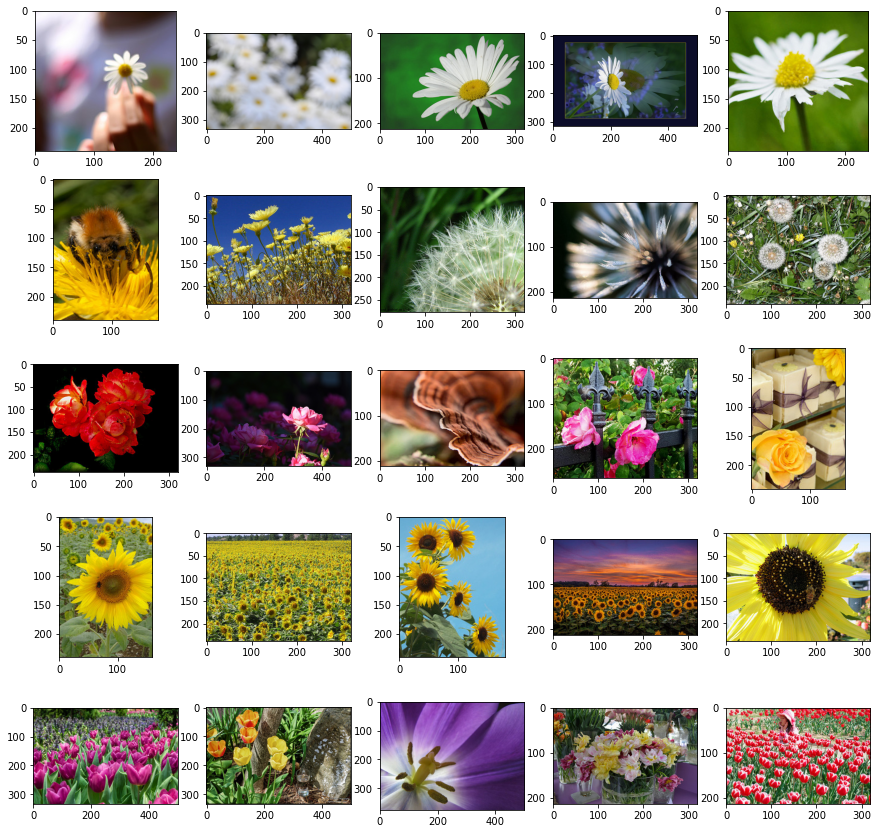

In [5]:
import matplotlib.pyplot as plt
import PIL

daisy = list(data_dir.glob('daisy/*'))[0:5]
dandelion = list(data_dir.glob('dandelion/*'))[0:5]
roses  = list(data_dir.glob('roses/*'))[0:5]
sunflowers  = list(data_dir.glob('sunflowers/*'))[0:5]
tulips = list(data_dir.glob('tulips/*'))[0:5]

images = [daisy, dandelion, roses, sunflowers, tulips]
COLUMNS=5
ROWS=len(images)

f, axarr = plt.subplots(5, 5, figsize=(15,15))
curr_row = 0

for row, image_row in enumerate(images):
  for col, image_col in enumerate(image_row):
    image = PIL.Image.open(image_col)
    axarr[row, col].imshow(image)

Let's load these images off disk using the helpful [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) in just a couple lines of code.

In [6]:
NUM_CLASSES = 5
INPUT_SHAPE=(180,180,3)

# Load all of the images into a tf.data.Dataset. Why do you not create a train
# and validation
# split here, similar to the Tensorflow tutorial? This is because of a limitation with
# the image_dataset_from_directory function and the way it handles shuffling. The ideal
# training regime consists of:
# 
# - a training set, which is used for back propagation against your model
# - a validation set, to measure the performance of your training
# - a test (holdout) set, to measure the performance of your *trained* model
#
# It is vitally important that your test data is never seen by your training loop. And equally
# important, your training and validation sets must never co-mingle. Keras 
# image_dataset_from_directory() can only create 2 splits, so you can either have a train/val split
# or a train/test split. Due to the way the Flowers dataset is constructed on disk, you need
# to use shuffle=True (the default) with a fixed seed when creating both splits, otherwise your splits
# will not contain examples from every class. This is the code you see in the Image classification
# tutorial. That tutorial only uses a train/val split because it trains for a fixed number of epochs,
# and it requires you to use the results from the last epoch, otherwise you have implicitly overfit
# your data to your holdout set, which will hurt your generalization performance at inference time
# when you see novel examples. So how can you get a train/val/test split from image_dataset_from_directory?
# The naive approach would be to create a train and test split, and then split the test dataset
# into a validation and holdout dataset (or equivalently, split the train set into a train/val set).
# This will not work however, because image_dataset_from_directory includes a shuffle operation, which
# reshuffles the data at each iteration through the dataset. So naively splitting one of the returned
# datasets will actually mix these datasets together at each epoch, introducing dataset co-mingling
# inadvertently.
#
# So how do you get a train/test/val split? You use image_dataset_from_directory() WITHOUT shuffling,
# to grab all of the data. Since this dataset is deterministic, You can then manually split this dataset
# into train and test (holdout). Masterful will automatically create a validation split from the training
# data, so you don't need to worry about that part, and Masterful will never see the test dataset,
# so there is no risk of overfitting to your test/holdout data.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
  shuffle=False,
  label_mode='categorical',
)

# Masterful works with unbatched datasets. Unfortunately image_dataset_from_directory
# only provides batched data, so you need to manually unbatch it here.
dataset = dataset.unbatch()

# Split the data into a labeled set for training and a test dataset for evaluation.
# Note the test_dataset will never be seen by Masterful. In this way, you can
# ensure that your training will never overfit to your holdout dataset.
# You use an internal utility of Masterful for convenience here, but any method
# of splitting the dataset, such as filtering (https://www.tensorflow.org/api_docs/python/tf/data/Dataset#filter),
# works equally well.
training_dataset, test_dataset = masterful.utils.dataset.split_dataset(
  dataset, 0.2)

# The TF guide uses a recscaling layer in the model to normalize
# input into the [0,1] range. That layer only exists in TF 2.6+,
# so we will manually normalize the dataset instead.
training_dataset = training_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

Found 3670 files belonging to 5 classes.


## Build the Model

Use the same model as the Tensorflow [Image Classification](https://www.tensorflow.org/tutorials/images/classification) tutorial, so that you can compare the results to that guide. Notice that the model is outputting logits rather than a softmax activation. 

Note that for the vast majority of projects, you'll want to use an existing model architecture from the `tf.keras.applications` module, and transfer learn from pretrained weights (typically Imagenet). 

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=INPUT_SHAPE),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0

## Train with Masterful

The Masterful AutoML platform learns how to train your model by focusing on five core organizational principles in deep learning: architecture, data, optimization, regularization, and semi-supervision.

**Architecture** is the structure of weights, biases, and activations that define a model. In this example, the architecture is defined by the model you created above.

**Data** is the input used to train the model. In this example, you are using a labeled training dataset of flowers. More advanced usages of the Masterful AutoML platform can take into account unlabeled and synthetic data as well, using a variety of different techniques.

**Optimization** means finding the best weights for a model and training data. Optimization is different from regularization because optimization does not consider generalization to unseen data. The central challenge of optimization is speed - find the best weights faster.

**Regularization** means helping a model generalize to data it has not yet seen. Another way of saying this is that regularization is about fighting overfitting.

**Semi-Supervision** is the process by which a model can be trained using both labeled and unlabeled data.

The first step when using Masterful is to learn the optimal set of parameters for each of the five buckets above. You start by learning the architecture and data parameters of the model and training dataset. In the code below, you are telling Masterful that your model is performing a classification task (`masterful.enums.Task.CLASSIFICATION`) with 5 labels (`num_classes=NUM_CLASSES`), and that the input range of the image features going into your model are in the range [0,255] (`input_range=masterful.enums.ImageRange.ZERO_255`). Also, the model outputs logits rather than a softmax classification (`prediction_logits=True`).

Furthermore, in the training dataset, you are providing dense labels (`sparse_labels=False`) rather than sparse labels.

For more details on architecture and data parameters, see the API specifications for [ArchitectureParams](../api/api_architecture.rst#masterful.architecture.ArchitectureParams) and [DataParams](../api/api_data.rst#masterful.data.DataParams). 

In [8]:
model_params = masterful.architecture.learn_architecture_params(
  model=model,
  task=masterful.enums.Task.CLASSIFICATION,
  input_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  prediction_logits=True,
)
training_dataset_params = masterful.data.learn_data_params(
  dataset=training_dataset,
  task=masterful.enums.Task.CLASSIFICATION,
  image_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  sparse_labels=False,
)

Next you learn the optimization parameters that will be used to train the model. Below, you use Masterful to learn the standard set of optimization parameters to train your model for a classification task.

For more details on the optmization parameters, please see the [OptimizationParams](../api/api_optimization.rst#masterful.optimization.OptimizationParams) API specification.

In [9]:
optimization_params = masterful.optimization.learn_optimization_params(
  model,
  model_params,
  training_dataset,
  training_dataset_params,
)

The regularization parameters used can have a dramatic impact on the final performance of your trained model. Learning these parameters can be a time-consuming and domain specific challenge. Masterful can speed up this process by learning these parameters for you. In general, this can be an expensive operation. A rough order of magnitude for learning these parameters is 2x the time it takes to train your model. However, this is still dramatically faster than manually finding these parameters yourself. In the example below, you will use the [learn_regularization_params](../api/api_regularization.rst#masterful.regularization.learn_regularization_params) API to learn these parameters directly from your dataset and model.

For more details on the regularization parameters, please see the [RegularizationParams](../api/api_regularization.rst#masterful.regularization.RegularizationParams) API specification.

In [10]:
regularization_params = masterful.regularization.learn_regularization_params(
  model,
  model_params,
  optimization_params,
  training_dataset,
  training_dataset_params,
)


MASTERFUL: Meta-Learning Regularization Parameters...
MASTERFUL: Warming up model for analysis.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 510 steps.
100%|██████████| 510/510 [02:54<00:00,  2.91steps/s]
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Analyzing baseline model performance. Training until validation loss stabilizes...
Baseline Training: 100%|██████████| 2325/2325 [10:15<00:00,  3.78steps/s]  
MASTERFUL: Baseline training complete.
MASTERFUL: Meta-Learning Basic Data Augmentations...
Node 4/4: 100%|██████████| 1860/1860 [08:40<00:00,  3.57steps/s] 
MASTERFUL: Meta-Learning Data Augmentation Clusters...
Node 10/10: 100%|██████████| 1860/1860 [09:31<00:00,  3.25steps/s] 
MASTERFUL: Meta-Learning Label Based Regularization...
Node 2/2: 100%|██████████| 1860/1860 [09:46<00:00,  3.17steps/s] 
MASTERFUL: Meta-Learning Weight Based Regularizat

The final step before training is to learn the optimal set of semi-supervision parameters. For this Quickstart, we are not using any unlabeled or synthetic data as part of training, so most forms of semi-supervision will be disabled by default.

For more details on the semi-supervision parameters, please see the [SemiSupervisedParams](../api/api_ssl.rst#masterful.ssl.SemiSupervisedParams) API specification.

In [11]:
ssl_params = masterful.ssl.learn_ssl_params(
  training_dataset,
  training_dataset_params,
)

Now, you are ready to train your model. In the next cell, you will see the call to [masterful.training.train](../api/api_training.rst#masterful.training.train), which is the entry point to the Masterful meta-learning engine. Notice there is no need to batch your data (Masterful will find the optimal batch size for you). No need to shuffle your data (Masterful handles this for you). You don't even need to pass in a validation dataset (Masterful finds one for you). You hand Masterful a model and a dataset, and Masterful will figure the rest out for you.

In [12]:
training_report = masterful.training.train(
  model, 
  model_params, 
  optimization_params,
  regularization_params,
  ssl_params,
  training_dataset,
  training_dataset_params,
)

MASTERFUL: Training model with semi-supervised learning disabled.
MASTERFUL: Performing basic dataset analysis.
MASTERFUL: Masterful will use 293 labeled examples as a validation set since no validation data was provided.
MASTERFUL: Training model with:
MASTERFUL: 	2643 labeled examples.
MASTERFUL: 	293 validation examples.
MASTERFUL: 	0 synthetic examples.
MASTERFUL: 	0 unlabeled examples.
MASTERFUL: Training model with learned parameters soarer-funny-background in two phases.
MASTERFUL: The first phase is supervised training with the learned policy.
MASTERFUL: The second phase is semi-supervised training to boost performance.
MASTERFUL: Warming up model for supervised training.
MASTERFUL: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL: 	Warming up training for 510 steps.
100%|██████████| 510/510 [03:09<00:00,  2.69steps/s]
MASTERFUL: 	Validating batch norm statistics after warmup for stability (this could take a few minutes).
MASTERFUL: Starting Phase 1:

## Analyze the Results

Now that the model is trained, its important to understand how the model will perform when introduced to data it has never seen before. This is why we created holdout set (`test_dataset`) earlier. Your model has never seen this data during training, so it can be a good estimate for the generalization performance of the model.

In [13]:
model.evaluate(
  test_dataset.batch(optimization_params.batch_size), 
  return_dict=True,
)

23/23 [==============================] - 8s 338ms/step - loss: 0.6870 - categorical_accuracy: 0.7316


{'loss': 0.6869918704032898, 'categorical_accuracy': 0.7316076159477234}

As you can see above, the model achieves `73.1%` accuracy on the test dataset. This is an excellent result, as the Tensorflow tutorial model only achieved `68.9%` accuracy, and that was after manually selecting and tuning augmentations and inserting dropout with an experimentally determined dropout rate. Masterful has handled all of these details for you, so that you can focus on solving your customer use cases, rather than getting bogged down in the details of model and the intricacies of training with best practices and state of the art research. 